In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, Image
import pickle

In [2]:
path = 'results/nLE_nLED_cifer10/'

## load data

In [3]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
print(len(X_train))
print(len(X_test))
print(X_train.shape)

50000
10000
(50000, 32, 32, 3)


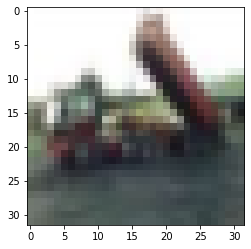

In [5]:
imgplot = plt.imshow(X_train[2])
plt.show()

## preprocessing/F.E.

## set parameter

# imageshuffle

In [6]:
train_data = pd.DataFrame({'x':[*X_train],'y':[*Y_train]})
test_data = pd.DataFrame({'x':[*X_test],'y':[*Y_test]})
# train_data = train_data.loc[train_data['y']<5]
# test_data = test_data.loc[test_data['y']<5]
data = [train_data,test_data]

In [7]:
for d in data:
    d['nor_x'] = d['x'].apply(lambda x:x/255)
    d['cate_y']=[*tf.keras.utils.to_categorical(d['y'])]

In [8]:
data[0]

,x,y,nor_x,cate_y
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...",[6],"[[[0.23137254901960785, 0.24313725490196078, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,"[[[154, 177, 187], [126, 137, 136], [105, 104,...",[9],"[[[0.6039215686274509, 0.6941176470588235, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[[[255, 255, 255], [253, 253, 253], [253, 253,...",[9],"[[[1.0, 1.0, 1.0], [0.9921568627450981, 0.9921...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...",[4],"[[[0.10980392156862745, 0.09803921568627451, 0...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[[170, 180, 198], [168, 178, 196], [177, 185,...",[1],"[[[0.6666666666666666, 0.7058823529411765, 0.7...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
49995,"[[[145, 161, 194], [151, 166, 199], [156, 171,...",[2],"[[[0.5686274509803921, 0.6313725490196078, 0.7...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49996,"[[[255, 245, 132], [254, 247, 134], [255, 249,...",[6],"[[[1.0, 0.9607843137254902, 0.5176470588235295...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
49997,"[[[35, 178, 235], [40, 176, 239], [42, 176, 24...",[9],"[[[0.13725490196078433, 0.6980392156862745, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
49998,"[[[189, 211, 240], [186, 208, 236], [185, 207,...",[1],"[[[0.7411764705882353, 0.8274509803921568, 0.9...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
train_x =np.array([[*a]for a in data[0]['nor_x']])
train_y =np.array([[*a]for a in data[0]['cate_y']])
test_x =np.array([[*a]for a in data[1]['nor_x']])
test_y =np.array([[*a]for a in data[1]['cate_y']])

## Training

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Input,\
                                    Lambda,MaxPooling2D, GlobalAveragePooling2D,\
                                    Add, Concatenate,BatchNormalization
from tensorflow.keras.models import Model

from moudule.padding import PaddingReplicate2D
from moudule.pixelshuffle import PixelShuffle
from moudule.pixelshuffle import PixelShuffle_calc, PixelShuffle_shape

from keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import CSVLogger

In [15]:
def resnet2(input_shape, nb_classes=10):
    p1 = PaddingReplicate2D((1,1))
    inp = Input(shape=input_shape)
    x = inp

#     # block0 ####################################################
#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*3, (4,4), padding='valid', strides=(4,4), kernel_initializer='he_normal' ) (x)
#     x = Activation('relu') (x)
#     # 8x8x48
    
#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*3, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
#     x = Activation('relu') (x)
#     # 8x8x48

#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*3, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
#     x = Activation('relu') (x)
#     # 8x8x48

#     x = BatchNormalization() (x)
#     x = Conv2D( 4*4*32, (1,1), padding='valid', kernel_initializer='he_normal' ) (x)
#     x = PixelShuffle( x, 4 )
#     # 32x32x32
    
    x = Conv2D( 64, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Conv2D( 128, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = MaxPooling2D(pool_size=(2, 2)) (x)
    x = Conv2D( 128, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Conv2D( 128, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = MaxPooling2D(pool_size=(2, 2)) (x)
    x = Conv2D( 512, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = MaxPooling2D(pool_size=(2, 2)) (x)
    x = Conv2D( 512, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Conv2D( 512, (3,3), padding='same', kernel_initializer='he_normal' ) (x)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation('relu') (x)
    x = Dropout(0.25) (x)
    x = Dense(10)(x)
    x = Activation('softmax') (x)
    
    return Model(inputs=inp, outputs=x)

In [16]:
model = resnet2(input_shape=[32,32,3], nb_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                           

Epoch 1/50
782/782 [==============================] - 71s 86ms/step - loss: 1.5794 - accuracy: 0.4386 - val_loss: 1.3038 - val_accuracy: 0.5611
Epoch 2/50
782/782 [==============================] - 67s 85ms/step - loss: 1.0032 - accuracy: 0.6518 - val_loss: 0.9343 - val_accuracy: 0.6815
Epoch 3/50
782/782 [==============================] - 68s 87ms/step - loss: 0.7636 - accuracy: 0.7439 - val_loss: 0.8127 - val_accuracy: 0.7213
Epoch 4/50
782/782 [==============================] - 70s 90ms/step - loss: 0.6235 - accuracy: 0.7936 - val_loss: 0.8926 - val_accuracy: 0.7260
Epoch 5/50
782/782 [==============================] - 70s 90ms/step - loss: 0.5160 - accuracy: 0.8324 - val_loss: 1.0183 - val_accuracy: 0.6970
Epoch 6/50
782/782 [==============================] - 71s 90ms/step - loss: 0.4274 - accuracy: 0.8616 - val_loss: 0.6056 - val_accuracy: 0.8071
Epoch 7/50
782/782 [==============================] - 71s 91ms/step - loss: 0.3488 - accuracy: 0.8858 - val_loss: 0.5738 - val_accuracy:

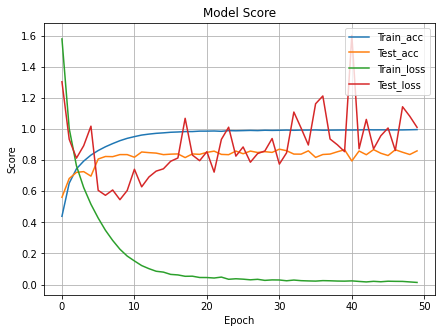

In [17]:
epochs = 50
batch_size = 64
csv_logger = CSVLogger(path+'log/log.csv', append=True, separator=';')

his = model.fit(train_x, 
            train_y, 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=1,
            validation_data=(test_x, test_y),
            callbacks=[csv_logger]
            )

model.save(path+'model/model'+'.h5')
with open(path+'his/his.pkl', 'wb') as fp:
    pickle.dump(his.history, fp)
    
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)
plt.plot(his.history["accuracy"])
plt.plot(his.history["val_accuracy"])
plt.plot(his.history["loss"])
plt.plot(his.history['val_loss'])
plt.title("Model Score")
plt.ylabel("Score")
plt.xlabel("Epoch")
# ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train_acc", "Test_acc","Train_loss", "Test_loss"], loc="upper right")
plt.grid()
plt.savefig(path+"loss/loss"+".png",dpi=1000)
plt.show()

In [18]:
result = pd.DataFrame({"True_value":data[1]['y']})

In [19]:
pred_y = model.predict( test_x )
result['model'] = [*pred_y]
acc = categorical_accuracy( test_y, pred_y )
np.mean(acc)

0.8594

In [20]:
result.to_pickle(path+'pre_test_result.pkl')